In [1]:
# CNTK 2.1 installálása Anaconda 3 alá itt található:
# https://docs.microsoft.com/en-us/cognitive-toolkit/setup-windows-python?tabs=cntkpy21
from IPython.display import Image
import matplotlib.pyplot as plt
import numpy as np
import os
import cntk as C

In [2]:
# ha nincs megfelelő videókártya, vagy CUDA 8 támogatás, akkor csak CPU fog menni.
# Ekkor a batch noramlizációs változatok nem működnek
isGPUEnabled = True
if isGPUEnabled == True:
    C.device.try_set_default_device(C.device.gpu(0))
else:
    C.device.try_set_default_device(C.device.cpu())

In [3]:
# ahol a notebookhoz képest az adatbázis van, azt kell itt referálni
data_path = os.path.join('..','Examples','Image', 'Datasets','CarsDemo')
# model dimenziói
image_height = 36
image_width  = 36
num_channels = 3
num_classes  = 2

import cntk.io.transforms as xforms 
#
# Ezzel olvasható be a tréning és a teszt adat
#
def create_reader(map_file, train):
    print("Reading map file:", map_file)
    
    if not os.path.exists(map_file):
        raise RuntimeError("This tutorials depends...")

    transforms = []
    # tréning során laterálisan augmentálunk
    if train:
        transforms += [
            xforms.crop(crop_type='randomside', side_ratio=0.75) 
        ]
    else:
        transforms += [
            xforms.crop(crop_type='center', side_ratio=0.75) 
        ]
    transforms += [
        xforms.scale(width=image_width, height=image_height, channels=num_channels, interpolations='linear')
    ]
    # deserializer
    return C.io.MinibatchSource(C.io.ImageDeserializer(map_file, C.io.StreamDefs(
        features = C.io.StreamDef(field='image', transforms=transforms), # first column in map file is referred to as 'image'
        labels   = C.io.StreamDef(field='label', shape=num_classes)      # and second as 'label'
    )))

In [4]:
# Readerek létrehozása
# Az eredeti adatbázis itt található:
# http://academictorrents.com/details/210dfc51f11dcfced602ad226962b7590e08c50a
reader_train = create_reader(os.path.join(data_path, 'car_training.txt'), True)
reader_test  = create_reader(os.path.join(data_path, 'car_testing.txt'), False) 

Reading map file: ..\Examples\Image\Datasets\CarsDemo\car_training.txt
Reading map file: ..\Examples\Image\Datasets\CarsDemo\car_testing.txt


In [5]:
#
# Hálózat tanítása és tesztelése
#
def train_and_evaluate(reader_train, reader_test, max_epochs, model_func):
    # Input variables denoting the features and label data
    input_var = C.input_variable((num_channels, image_height, image_width))
    label_var = C.input_variable((num_classes))
    # Normalize the input
    feature_scale = 1.0 / 256.0
    input_var_norm = C.element_times(feature_scale, input_var, name="features")  
    # apply model to input
    z = model_func(input_var_norm, out_dims = 2)

    # Training action

    # loss and metric
    ce = C.cross_entropy_with_softmax(z, label_var)
    pe = C.classification_error(z, label_var)
    # training config
    epoch_size     = 84227
    minibatch_size = 64
    # Set training parameters
    lr_per_minibatch       = C.learning_rate_schedule([0.01]*5 + [0.003]*5 + [0.001]*5 + [0.0003]*5 +[0.0001]*5 + [0.00003]*5 +[0.00001], 
                                                      C.UnitType.sample, epoch_size)
    #momentum_time_constant = C.momentum_as_time_constant_schedule(-minibatch_size/np.log(0.9))
    momentum_time_constant = C.momentum_schedule(0.9)
    l2_reg_weight          = 0.001
    
    # trainer object
    learner = C.momentum_sgd(z.parameters, 
                             lr = lr_per_minibatch, 
                             momentum = momentum_time_constant, 
                             l2_regularization_weight=l2_reg_weight)
    progress_printer = C.logging.ProgressPrinter(tag='Training', num_epochs=max_epochs)
    trainer = C.Trainer(z, (ce, pe), [learner], [progress_printer])

    # define mapping from reader streams to network inputs
    input_map = {
        input_var: reader_train.streams.features,
        label_var: reader_train.streams.labels
    }

    C.logging.log_number_of_parameters(z) ; print()

    # perform model training
    batch_index = 0
    plot_data = {'batchindex':[], 'loss':[], 'error':[]}
    for epoch in range(max_epochs):       # loop over epochs
        sample_count = 0
        while sample_count < epoch_size:  # loop over minibatches in the epoch
            data = reader_train.next_minibatch(min(minibatch_size, epoch_size - sample_count), 
                                               input_map=input_map) # fetch minibatch.
            trainer.train_minibatch(data)                                   # update model with it

            sample_count += data[label_var].num_samples                     # count samples processed so far
            
            # For visualization...            
            plot_data['batchindex'].append(batch_index)
            plot_data['loss'].append(trainer.previous_minibatch_loss_average)
            plot_data['error'].append(trainer.previous_minibatch_evaluation_average)
            
            batch_index += 1
        trainer.summarize_training_progress()
        
    # Evaluation action
    
    epoch_size     = 21057
    minibatch_size = 512

    # process minibatches and evaluate the model
    metric_numer    = 0
    metric_denom    = 0
    sample_count    = 0
    minibatch_index = 0

    while sample_count < epoch_size:
        current_minibatch = min(minibatch_size, epoch_size - sample_count)

        # Fetch next test min batch.
        data = reader_test.next_minibatch(current_minibatch, input_map=input_map)

        # minibatch data to be trained with
        metric_numer += trainer.test_minibatch(data) * current_minibatch
        metric_denom += current_minibatch

        # Keep track of the number of samples processed so far.
        sample_count += data[label_var].num_samples
        minibatch_index += 1

    print("")
    print("Final Results: Minibatch[1-{}]: errs = {:0.1f}% * {}".format(minibatch_index+1, (metric_numer*100.0)/metric_denom, metric_denom))
    print("")
    
    # Visualize training result:
    window_width            = 32
    loss_cumsum             = np.cumsum(np.insert(plot_data['loss'], 0, 0)) 
    error_cumsum            = np.cumsum(np.insert(plot_data['error'], 0, 0)) 

    # Moving average.
    plot_data['batchindex'] = np.insert(plot_data['batchindex'], 0, 0)[window_width:]
    plot_data['avg_loss']   = (loss_cumsum[window_width:] - loss_cumsum[:-window_width]) / window_width
    plot_data['avg_error']  = (error_cumsum[window_width:] - error_cumsum[:-window_width]) / window_width
    
    plt.figure(1)
    plt.subplot(211)
    plt.plot(plot_data["batchindex"], plot_data["avg_loss"], 'b--')
    plt.xlabel('Minibatch number')
    plt.ylabel('Loss')
    plt.title('Minibatch run vs. Training loss ')

    plt.show()

    plt.subplot(212)
    plt.plot(plot_data["batchindex"], plot_data["avg_error"], 'r--')
    plt.xlabel('Minibatch number')
    plt.ylabel('Label Prediction Error')
    plt.title('Minibatch run vs. Label Prediction Error ')
    plt.show()
    
    return C.softmax(z)

In [6]:
# Klasszikus CNN minden pedantéria nélkül
def create_basic_model(input, out_dims):
    with C.layers.default_options(init=C.glorot_uniform(), activation=C.relu):
        net = C.layers.Convolution((3,3), 8, pad=True)(input)
        net = C.layers.MaxPooling((3,3), strides=(2,2))(net)
        net = C.layers.Convolution((3,3), 16, pad=True)(net)
        net = C.layers.MaxPooling((3,3), strides=(2,2))(net)
        net = C.layers.Convolution((3,3), 32, pad=True)(net)
        net = C.layers.MaxPooling((3,3), strides=(2,2))(net)
        net = C.layers.Dense(32)(net)
        net = C.layers.Dense(out_dims, activation=None)(net)
    return net

In [7]:
# CNN batch normalizációval
def create_basic_model_with_batch_normalization(input, out_dims):
    with C.layers.default_options(activation = C.relu, init = C.glorot_uniform()):
        model = C.layers.Sequential([
            C.layers.For(range(3), lambda i: [
                C.layers.Convolution((3,3), [8,16,32][i], pad = True),
                C.layers.BatchNormalization(map_rank = 1),
                C.layers.MaxPooling((3,3), strides = (2,2))
            ]),
            C.layers.Dense(32),
            C.layers.Dense(out_dims, activation = None)
        ])
    return model(input)

In [8]:
# VGG like modell, de indításkor egy konvolúcióval és minden conv után batch normalizációval.
# Kimenet csak egy dense layeren keresztül, mert nincs sok komoly összefüggés
def create_vgg9_model(input, out_dims):
    with C.layers.default_options(activation=C.relu, init=C.glorot_uniform()):
        model = C.layers.Sequential([
            C.layers.Convolution((3,3), 8, pad=True, name='C1'),
            C.layers.BatchNormalization(map_rank = 1, name='BN1'),
            C.layers.MaxPooling((2,2), strides=(2,2), name='MP1'),
            C.layers.For(range(2), lambda i: [
                C.layers.Convolution((3,3), [16,32][i], pad=True, name='C'+str(i+2)),
                C.layers.BatchNormalization(map_rank = 1, name='BN1'+str(i+2)),
                C.layers.Convolution((3,3), [16,32][i], pad=True, name='C'+str(i+2)),
                C.layers.BatchNormalization(map_rank = 1, name='BN'+str(i+2)+'2'),
                C.layers.MaxPooling((2,2), strides=(2,2), name='MP'+str(i+2)+'2')
            ]),
            C.layers.Convolution((4,4), 32, pad=False, name='CF1'),
            C.layers.Convolution((1,1), 2, pad=False, name='CF2'),
            C.layers.Dense(out_dims, activation=None, name='Output')
        ])
    return model(input)

node_outputs = C.logging.get_node_outputs(create_vgg9_model(C.element_times(1/256.0, C.input_variable((3, 36, 36)), name="features")  ,2))
for l in node_outputs: print("  {0} {1}".format(l.name, l.shape))

  Output (2,)
  CF2 (2, 1, 1)
  CF1 (32, 1, 1)
  MP32 (32, 4, 4)
  BN32 (32, 9, 9)
  C3 (32, 9, 9)
  BN13 (32, 9, 9)
  C3 (32, 9, 9)
  MP22 (16, 9, 9)
  BN22 (16, 18, 18)
  C2 (16, 18, 18)
  BN12 (16, 18, 18)
  C2 (16, 18, 18)
  MP1 (8, 18, 18)
  BN1 (8, 36, 36)
  C1 (8, 36, 36)
  features (3, 36, 36)


In [9]:
# Az RNN-hez pár definiált segédfüggvény
def convolution_bn(input, filter_size, num_filters, strides=(1,1), init=C.he_normal(), activation=C.relu):
    if activation is None:
        activation = lambda x: x
        
    r = C.layers.Convolution(filter_size, 
                             num_filters, 
                             strides=strides, 
                             init=init, 
                             activation=None, 
                             pad=True, bias=False)(input)
    r = C.layers.BatchNormalization(map_rank=1)(r)
    r = activation(r)
    return r

def resnet_basic(input, num_filters):
    c1 = convolution_bn(input, (3,3), num_filters)
    c2 = convolution_bn(c1, (3,3), num_filters, activation=None)
    p  = c2 + input
    return C.relu(p)

def resnet_basic_inc(input, num_filters):
    c1 = convolution_bn(input, (3,3), num_filters, strides=(2,2))
    c2 = convolution_bn(c1, (3,3), num_filters, activation=None)
    s = convolution_bn(input, (1,1), num_filters, strides=(2,2), activation=None)
    p = c2 + s
    return C.relu(p)

def resnet_basic_stack(input, num_filters, num_stack):
    assert (num_stack > 0)
    r = input
    for _ in range(num_stack):
        r = resnet_basic(r, num_filters)
    return r

In [10]:
# RNN háló a végén a MS ajánlásával egy averagepool
def create_resnet_model(input, out_dims):
    conv = convolution_bn(input, (3,3), 8)
    r1_1 = resnet_basic_stack(conv, 8, 3)
    r2_1 = resnet_basic_inc(r1_1, 16)
    r2_2 = resnet_basic_stack(r2_1, 16, 3)
    r3_1 = resnet_basic_inc(r2_2, 32)
    r3_2 = resnet_basic_stack(r3_1, 32, 3)
    r4_1 = resnet_basic_inc(r3_2, 64)
    r4_2 = resnet_basic_stack(r4_1, 64, 3)
    # Global average pooling
    pool = C.layers.AveragePooling(filter_shape=(4,4), strides=(1,1))(r4_2)
    net = C.layers.Dense(out_dims, init=C.he_normal(), activation=None)(pool)   
    return net

Training 15346 parameters in 10 parameter tensors.

Learning rate per sample: 0.01
Momentum per minibatch: 0.9
Finished Epoch[1 of 40]: [Training] loss = 0.419075 * 84227, metric = 20.18% * 84227 14.712s (5725.1 samples/s);
Finished Epoch[2 of 40]: [Training] loss = 0.351949 * 84227, metric = 16.13% * 84227 7.470s (11275.4 samples/s);
Finished Epoch[3 of 40]: [Training] loss = 0.341414 * 84227, metric = 15.51% * 84227 7.637s (11028.8 samples/s);
Finished Epoch[4 of 40]: [Training] loss = 0.329185 * 84227, metric = 14.85% * 84227 7.336s (11481.3 samples/s);
Finished Epoch[5 of 40]: [Training] loss = 0.333363 * 84227, metric = 15.09% * 84227 7.376s (11419.1 samples/s);
Learning rate per sample: 0.003
Finished Epoch[6 of 40]: [Training] loss = 0.272681 * 84227, metric = 11.95% * 84227 7.536s (11176.6 samples/s);
Finished Epoch[7 of 40]: [Training] loss = 0.257544 * 84227, metric = 11.17% * 84227 7.884s (10683.3 samples/s);
Finished Epoch[8 of 40]: [Training] loss = 0.255775 * 84227, metri

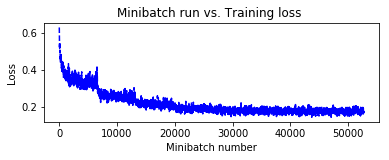

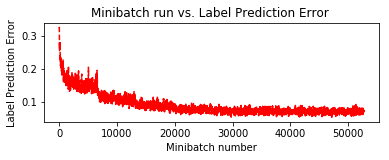

In [11]:
pred = train_and_evaluate(reader_train, 
                          reader_test, 
                          max_epochs = 40, 
                          model_func = create_basic_model)

Training 15458 parameters in 16 parameter tensors.

Learning rate per sample: 0.01
Momentum per minibatch: 0.9
Finished Epoch[1 of 40]: [Training] loss = 0.386441 * 84227, metric = 17.92% * 84227 8.803s (9568.0 samples/s);
Finished Epoch[2 of 40]: [Training] loss = 0.302735 * 84227, metric = 13.37% * 84227 9.657s (8721.9 samples/s);
Finished Epoch[3 of 40]: [Training] loss = 0.274566 * 84227, metric = 11.80% * 84227 9.899s (8508.6 samples/s);
Finished Epoch[4 of 40]: [Training] loss = 0.259743 * 84227, metric = 11.06% * 84227 9.712s (8672.5 samples/s);
Finished Epoch[5 of 40]: [Training] loss = 0.259187 * 84227, metric = 10.93% * 84227 10.120s (8322.8 samples/s);
Learning rate per sample: 0.003
Finished Epoch[6 of 40]: [Training] loss = 0.203235 * 84227, metric = 8.35% * 84227 9.498s (8867.9 samples/s);
Finished Epoch[7 of 40]: [Training] loss = 0.193805 * 84227, metric = 7.96% * 84227 9.626s (8749.9 samples/s);
Finished Epoch[8 of 40]: [Training] loss = 0.191078 * 84227, metric = 7.86

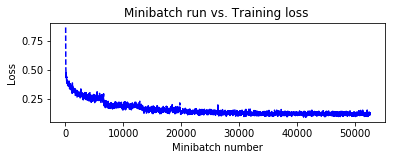

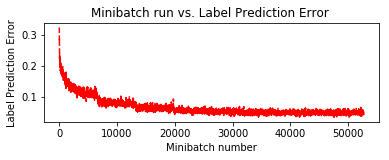

In [12]:
pred_basic_model_bn = train_and_evaluate(reader_train, 
                                         reader_test, 
                                         max_epochs=40, 
                                         model_func=create_basic_model_with_batch_normalization)

Training 34296 parameters in 26 parameter tensors.

Learning rate per sample: 0.01
Momentum per minibatch: 0.9
Finished Epoch[1 of 40]: [Training] loss = 0.357659 * 84227, metric = 16.16% * 84227 9.283s (9073.3 samples/s);
Finished Epoch[2 of 40]: [Training] loss = 0.250942 * 84227, metric = 10.28% * 84227 10.931s (7705.3 samples/s);
Finished Epoch[3 of 40]: [Training] loss = 0.225345 * 84227, metric = 9.17% * 84227 10.729s (7850.4 samples/s);
Finished Epoch[4 of 40]: [Training] loss = 0.223312 * 84227, metric = 9.16% * 84227 10.153s (8295.8 samples/s);
Finished Epoch[5 of 40]: [Training] loss = 0.220387 * 84227, metric = 8.94% * 84227 10.463s (8050.0 samples/s);
Learning rate per sample: 0.003
Finished Epoch[6 of 40]: [Training] loss = 0.161712 * 84227, metric = 6.32% * 84227 10.501s (8020.9 samples/s);
Finished Epoch[7 of 40]: [Training] loss = 0.151008 * 84227, metric = 5.85% * 84227 10.667s (7896.0 samples/s);
Finished Epoch[8 of 40]: [Training] loss = 0.150569 * 84227, metric = 5.

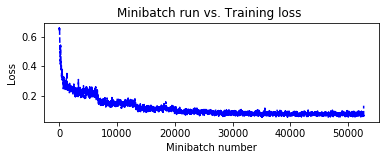

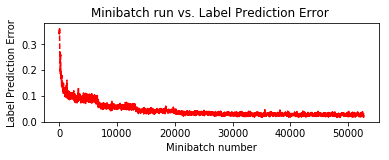

[Output('Softmax5533_Output_0', [#], [2]),
 Output('Output', [#], [2]),
 Output('CF2', [#], [2 x 1 x 1]),
 Output('CF1', [#], [32 x 1 x 1]),
 Output('MP32', [#], [32 x 4 x 4]),
 Output('BN32', [#], [32 x 9 x 9]),
 Output('C3', [#], [32 x 9 x 9]),
 Output('BN13', [#], [32 x 9 x 9]),
 Output('C3', [#], [32 x 9 x 9]),
 Output('MP22', [#], [16 x 9 x 9]),
 Output('BN22', [#], [16 x 18 x 18]),
 Output('C2', [#], [16 x 18 x 18]),
 Output('BN12', [#], [16 x 18 x 18]),
 Output('C2', [#], [16 x 18 x 18]),
 Output('MP1', [#], [8 x 18 x 18]),
 Output('BN1', [#], [8 x 36 x 36]),
 Output('C1', [#], [8 x 36 x 36]),
 Output('features', [#], [3 x 36 x 36])]

In [13]:
pred_vgg = train_and_evaluate(reader_train, 
                              reader_test, 
                              max_epochs=40,
                              model_func=create_vgg9_model)

C.logging.get_node_outputs(pred_vgg)

Training 371882 parameters in 104 parameter tensors.

Learning rate per sample: 0.01
Momentum per minibatch: 0.9
Finished Epoch[1 of 40]: [Training] loss = 0.432772 * 84227, metric = 19.17% * 84227 39.775s (2117.6 samples/s);
Finished Epoch[2 of 40]: [Training] loss = 0.275839 * 84227, metric = 11.88% * 84227 38.292s (2199.6 samples/s);
Finished Epoch[3 of 40]: [Training] loss = 0.218874 * 84227, metric = 9.03% * 84227 38.237s (2202.8 samples/s);
Finished Epoch[4 of 40]: [Training] loss = 0.196844 * 84227, metric = 7.81% * 84227 38.277s (2200.5 samples/s);
Finished Epoch[5 of 40]: [Training] loss = 0.183360 * 84227, metric = 7.20% * 84227 38.205s (2204.6 samples/s);
Learning rate per sample: 0.003
Finished Epoch[6 of 40]: [Training] loss = 0.131465 * 84227, metric = 4.98% * 84227 38.191s (2205.4 samples/s);
Finished Epoch[7 of 40]: [Training] loss = 0.123823 * 84227, metric = 4.68% * 84227 38.118s (2209.6 samples/s);
Finished Epoch[8 of 40]: [Training] loss = 0.124403 * 84227, metric =

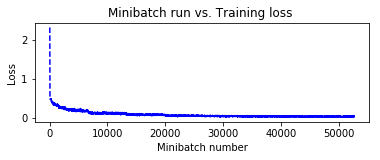

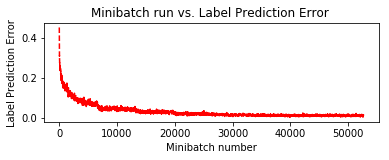

In [14]:
pred_resnet = train_and_evaluate(reader_train,
                                 reader_test,
                                 max_epochs=40,
                                 model_func=create_resnet_model)

In [15]:
pred.save("Cars_CNN.model")
pred_basic_model_bn.save("Cars_BCNN.model")
pred_vgg.save("Cars_VGG.model")
pred_resnet.save("Cars_Resnet.model")

In [16]:
pred_vgg = C.load_model("Cars_VGG.model")
pred_resnet = C.load_model("Cars_Resnet.model")

In [17]:
# kép ellenőrzés

from PIL import Image as Image2

def eval_single_image(loaded_model, image_path):
    # load and format image (resize, RGB -> BGR, CHW -> HWC)
    try:
        img = Image2.open(image_path).convert("RGBA")
        
        if image_path.endswith("png"):
            temp = Image2.new("RGBA", img.size, (255, 255, 255))
            temp.paste(img, img)
            img = temp
        resized = img.crop((img.width/2-18, img.height/2-18, img.width/2+18, img.height/2+18))
        bgr_image = np.asarray(resized, dtype=np.float32)[..., [2, 1, 0]]
        hwc_format = np.ascontiguousarray(np.rollaxis(bgr_image, 2))

        # compute model output
        arguments = {loaded_model.arguments[0]: [hwc_format]}
        output = loaded_model.eval(arguments)

        # return softmax probabilities
        sm = C.softmax(output[0])
        return sm.eval()
    except FileNotFoundError:
        print("Could not open (skipping file): ", image_path)
        return ['None']
        
# Evaluates an image set using the provided model
def eval_test_images(test_map_file, loaded_model):
    num_images = sum(1 for line in open(test_map_file))
        
    print("Evaluating model output node '{0}' for {1} images.".format('prediction', num_images))

    pred_count = 0
    correct_count = 0
    np.seterr(over='raise')
    with open(test_map_file, "r") as input_file:
        for line in input_file:
            tokens = line.rstrip().split('\t')
            img_file = tokens[0]
            probs = eval_single_image(loaded_model, img_file)
            
            if probs[0]=='None':
                print("Eval not possible: ", img_file)
                continue

            pred_count += 1
            true_label = int(tokens[1])
            predicted_label = np.argmax(probs)
            if predicted_label == true_label:
                correct_count += 1

            if pred_count % 1000 == 0:
                print("Processed {0} samples ({1:.2%} correct)".format(pred_count, 
                                                                       (float(correct_count) / pred_count)))
            if pred_count >= num_images:
                break
    print ("{0} of {1} prediction were correct".format(correct_count, pred_count))
    return correct_count, pred_count, (float(correct_count) / pred_count)

In [18]:
eval_test_images(os.path.join(data_path, 'car_testing.txt'), pred_vgg)

Evaluating model output node 'prediction' for 21057 images.
Processed 1000 samples (95.50% correct)
Processed 2000 samples (96.05% correct)
Processed 3000 samples (96.60% correct)
Processed 4000 samples (96.70% correct)
Processed 5000 samples (96.98% correct)
Processed 6000 samples (96.88% correct)
Processed 7000 samples (97.07% correct)
Processed 8000 samples (96.91% correct)
Processed 9000 samples (97.06% correct)
Processed 10000 samples (97.17% correct)
Processed 11000 samples (97.28% correct)
Processed 12000 samples (97.32% correct)
Processed 13000 samples (97.47% correct)
Processed 14000 samples (97.55% correct)
Processed 15000 samples (97.55% correct)
Processed 16000 samples (97.57% correct)
Processed 17000 samples (97.41% correct)
Processed 18000 samples (97.51% correct)
Processed 19000 samples (97.61% correct)
Processed 20000 samples (97.59% correct)
Processed 21000 samples (97.57% correct)
20546 of 21057 prediction were correct


(20546, 21057, 0.975732535498884)

In [19]:
# Clone the desired layers with fixed weights
feature_node = C.logging.find_by_name(pred_vgg, 'features')
last_node = C.logging.find_by_name(pred_vgg, 'CF2')
cloned_layers = C.combine([last_node.owner]).clone(C.CloneMethod.freeze, {feature_node: C.placeholder(name='features')})

image_input = C.input_variable((3,1024,1024))
cloned_out = cloned_layers(C.element_times(1/256.0, image_input, name="features"))
z = C.layers.Dense(2, activation=None, name="out") (cloned_out)
node_outputs = C.logging.get_node_outputs(cloned_out)
for l in node_outputs: print("  {0} {1}".format(l.name, l.shape))

  CF2 (2, 125, 125)
  CF2 (2, 125, 125)
  CF1 (32, 125, 125)
  MP32 (32, 128, 128)
  BN32 (32, 256, 256)
  C3 (32, 256, 256)
  BN13 (32, 256, 256)
  C3 (32, 256, 256)
  MP22 (16, 256, 256)
  BN22 (16, 512, 512)
  C2 (16, 512, 512)
  BN12 (16, 512, 512)
  C2 (16, 512, 512)
  MP1 (8, 512, 512)
  BN1 (8, 1024, 1024)
  C1 (8, 1024, 1024)
  features (3, 1024, 1024)


In [20]:
cloned_out.save("Cars_VGG_Big.model")